### Задание 1
&emsp;Платформу будет использовать человек, только что открывший парикмахерскую по адресу г. Тверь, ул. Трехсвятская, д. 3, который хочет привлечь как можно больше новых клиентов.  
Задача - использовать данные, которые у нас имеются, чтобы:  
1) Описать алгоритм, который позволит ему собрать сегмент абонентов.  
2) Предложить наиболее подходящий способ привлечения новых клиентов. 

&emsp;Чаще всего парикмахерская - это бизнес, нацеленный на локальную аудиторию. В случае, если мы рассматриваем один из нескольких салонов премиум класса в городе, то тогда мы не так привязаны к географии потребителей - люди, которые готовы платить за стрижку наверняка не ищут самую ближайшую парикмахерскую. Но если парикмахерская, которую открывает наш клиент рассчитана на среднестатистического человека, то разумнее будет выделить тех пользователей, которые живут в *центральном* районе Твери, т.е. в непосредственной близости к Трёхсвятской д.3.  
&emsp;Далее, к наиболее интересной для клиента аудитории мы отнесём тех людей, что заходили на сайты, связанные с тематикой парикмахерских (другие салоны красоты, магазины косметики и т.д.) или совершали звонки в подобные организации  
&emsp;Пояснения по поводу SQL запроса я напишу в конце
  
###### *мне кажется 20 - 30 минут на это задание - маловато, если учитывать необходимость писать код*

Для начала просто объединим имеющиеся таблицы  
Сначала я пытался сджойнить все данные разом, но для таблиц cnum_d, geo_d и cities_regions выгружена информация лишь по одному пользователю  
Поэтому cnum_d, geo_d и cities_regions я объединил в users_area. Здесь мы отберём жителей центрального региона Твери  

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

users_area = pd.read_csv("SHIFT data/cnum_d.csv").merge(pd.read_csv("SHIFT data/geo_d.csv"), on="msisdn") \
                                                 .rename(columns={"ts_x":"call_time", "ts_y":"location_time"}) \
                                                 .merge(pd.read_csv("SHIFT data/cities_regions.csv")[['geo_area_key', 'city_name', 'city_area']], on="geo_area_key")
users_area["call_type"], users_area["direction"] = users_area["call_type"].replace({1:"звонок", 2:"SMS"}), users_area["direction"] \
                                                                          .replace({"0":"исходящий", "I":"входящий"})
users_area.head()

,msisdn,call_time,called_party_number,call_type,direction,location_time,geo_area_key,city_name,city_area
0,66b0622396613f6f1b7f3f4e5a509f18,2022-09-29 03:11:20,79128061642,звонок,входящий,2022-02-21 10:49:45,87283601419,Тверь,Центральный
1,66b0622396613f6f1b7f3f4e5a509f18,2022-09-29 03:11:20,79128061642,звонок,входящий,2022-01-25 03:29:19,87283601419,Тверь,Центральный
2,66b0622396613f6f1b7f3f4e5a509f18,2022-09-29 03:11:20,79128061642,звонок,входящий,2022-03-04 07:18:46,87283601419,Тверь,Центральный
3,66b0622396613f6f1b7f3f4e5a509f18,2022-09-29 03:11:20,79128061642,звонок,входящий,2022-11-21 12:57:40,87283601419,Тверь,Центральный
4,66b0622396613f6f1b7f3f4e5a509f18,2022-09-29 03:11:20,79128061642,звонок,входящий,2022-12-09 07:55:26,87283601419,Тверь,Центральный


Но для таблиц host_d, twogis_hosts, twogis_phones данные представлены по другим пользователям, не по тем, что есть в area_users, поэтому я выделил оставшиеся таблицы второй датафрейм - users_interests.

In [143]:
users_interests = pd.read_csv("SHIFT data/host_d.csv").merge(pd.read_csv("SHIFT data/host_d.csv") \
                    .rename(columns={"host_name":"host"}), on="host")
twogis_phones = pd.read_csv("SHIFT data/twogis_phones.csv") \
                  .rename(columns={"called_party_number":"phone_num"})
users_interests
# При правильной выгрузке данных финальное объединение будет выглядеть так:
# users_area.merge(users_interests, on="msisdn").merge(twogis_phones, on="called_party_number")

,msisdn,ts,host,rubric,organization_name,phone_num
0,3ae06583aa2560b723ae06583aaf619f,2022-08-22 06:38:31,masters-masters.ru,Парикмахерские,Мастерс,79342202164
1,fd9fbd0ae902560b723ae06583aaf619,2022-05-08 04:26:42,masters-masters.ru,Парикмахерские,Мастерс,79342202164
2,583aaf619f2560b723ae06583aaf619f,2022-11-18 06:20:58,masters-masters.ru,Парикмахерские,Мастерс,79342202164
3,ae06583aaf6192560b723ae06583aaf6,2022-06-16 10:52:21,trosani-b.ru,Парикмахерские,Салон красоты Trosani,79040002888
4,fd9fbd0ae902560b723ae06583aaf619,2022-05-03 08:13:03,trosani-b.ru,Парикмахерские,Салон красоты Trosani,79040002888
5,2560b723ae06583aaf619fd9fbd0ae90,2022-02-28 02:40:30,trosani-b.ru,Парикмахерские,Салон красоты Trosani,79040002888
6,2560b723ae06583aaf619fd9fbd0ae90,2022-12-15 06:22:48,marinastylist.ru,Парикмахерские,Marina Stylist,79157469112


Для верной сегментации нам необходимо объединить area_users и users_interests в один набор данных. Здесь не вышло это сделать ни по номеру пользователя, ни по номеру телефона организации. Единственное, что мы можем сейчас - отобрать толко тех пользователей из users_area, для которых город = Тверь и регион = Центральный, но в geo_d это уже сделали за нас, отобрав значения с geo_area_key = 87283601419, что и относится к центру Твери.

&emsp;Чаще всего парикмахерская - это бизнес, нацеленный на локальную аудиторию. В случае, если мы рассматриваем один из нескольких салонов премиум класса в городе, то тогда мы не так привязаны к географии потребителей - люди, которые готовы платить за стрижку наверняка не ищут самую ближайшую парикмахерскую. Но если парикмахерская, которую открывает наш клиент рассчитана на среднестатистического потребителя, то разумнее будет выделить тех пользователей, которые живут в Центральном районе Твери, т.е. в непосредственной близости к Трёхсвятской д.3.  
Далее, к наиболее интересной для клиента аудитории мы отнесём тех людей, что заходили на сайты, связанные с тематикой парикмахерских или совершали звонки в подобные организации  
&emsp;Сделаю небольшое допущение и предположу, что для каждого пользователя МТС собирается полная информация о звонках, о посещениях сайтов и о геолокации.  
Тогда выгрузим объединённую таблицу. В неё войдут те пользователи, которые проживают в Твери, которые хоть раз были в Центральном районе и которые либо посещали сайт с rubric = Парикмахерская OR = Барбершоп, либо звонили в организацию с такой же rubric. Без БД под рукой будет проблематично написать такой SQL запрос без синтаксических ошибок, но я попробую:  
&emsp;&emsp;&emsp;*SELECT cd.msisdn,  cd.called_party_number, geo.geo_area_key, geo.ts as location_time, cities.city_name, cities.city_area, host_d.host, twogis_hosts.rubric as site_type, twogis_phones.rubric as call_type  
&emsp;&emsp;&emsp;FROM cnum_d as cd*  
&emsp;&emsp;&emsp;*JOIN geo_d as geo ON cd.msisdn = geo.msisdn*  
&emsp;&emsp;&emsp;*JOIN cities_regions as cities ON geo.geo_area_key = cities.geo_area_key*  
&emsp;&emsp;&emsp;*WHERE cities.city_name = “Тверь”*  
&emsp;&emsp;&emsp;*LEFT JOIN host_d ON host_d.msisdn = cd.msisdn*  
&emsp;&emsp;&emsp;*JOIN twogis_hosts ON host_d.host = twogis_hosts.host_name*  
&emsp;&emsp;&emsp;*WHERE cd.msisdn IN  
&emsp;&emsp;&emsp;(SELECT host_d.msisdn FROM host_d JOIN twogis_hosts ON host_d.host = twogis_hosts.host_name WHERE twogis_hosts.rubric = “Парикмахерская” OR twogis_hosts.rubric = “Барбершоп”)*  
&emsp;&emsp;&emsp;*LEFT JOIN twogis_phones ON twogis_phones.phone_num = cd. called_party_number AND (twogis_phones.rubric = “Парикмахерская” OR twogis_phones.rubric = “Барбершоп”)*  
Как мне кажется, стоит выгружать только пользователей из Твери, без привязки к Центральному региону, т.к. местоположение обновляется каждые 10 минут, и некоторые пользователи могли находиться в этом районе всего несколько часов за месяц. Уже в Python можно рассчитать долю пользователей по длительности пребывания по районам. Потом мы присоединяем тех пользователей, кто хоть раз заходил на сайт парикмахерской или барбершопа, а также тех, кто хоть раз звонил в такие организации (или кому звонили)


&emsp;Отвечу на второй вопрос. Самыми эффективными способами обратить внимание потребителей на юр.лицо вроде парикмахерской будут: добавить свою организацию на карты (ГИС, Яндекс) и максимально информативно заполнить карточку; создать сайт парикмахерской и установить релевантные тэги для поисковых запросов; заказать таргетированную рекламную компанию с промо - акцией для клиентов.  
&emsp;Я выбрал эти способы в первую очередь из - за особенностей клиентуры салонов красоты. Стрижка в парикмахерской почти никогда не откладывается на несколько недель. Чаще всего, человек, который нуждается в подобной услуге, сам начинает искать по картам или в поисковике запись на ближайший день в ближайших к дому парикмахерских. А тот, кто поход к парикмахеру не планирует, скорее всего будет игнорировать встречающуюся ему рекламу. Но если он увидит выгодную акцию, то это может его заинтересовать.

### Задание 2
Допишите SQL-запрос так, чтобы в результате были доступны пары разных цветов, не повторяющихся при их смешивании. То есть нам подходят пары «красный + зеленый», «красный + синий», однако пары «красный + красный» или «зеленый + красный» недопустимы:

In [89]:
import pyodbc
import pandas.io.sql as psql
cnxn = pyodbc.connect("DRIVER={SQL Server};SERVER=DESKTOP-CO6L7KN\SHEOGORATH;DATABASE=colors;Trusted_Connection=yes;")
cursor = cnxn.cursor()
# Мой вариант чтения данных из запроса:
# sql = cursor.execute("""with a as (select 'Красный' as color \
#     union all select 'Зеленый' as color \
#     union all select 'Синий' as color \
#     union all select 'Желтый' as color \
#     union all select 'Фиолетовый' as color \
#     union all select 'Пурпурный' as color \
#     union all select 'Белый' as color) \
#     SELECT a1.color as first_color, a2.color as second_color FROM a as a1 \
#     JOIN a as a2 ON a1.color > a2.color""")
# df = pd.DataFrame([list(i) for i in sql])

#Более простой вариант с Stackoverflow:
df = pd.read_sql_query(sql="with a as (select 'Красный' as color \
    union all select 'Зеленый' as color \
    union all select 'Синий' as color \
    union all select 'Желтый' as color \
    union all select 'Фиолетовый' as color \
    union all select 'Пурпурный' as color \
    union all select 'Белый' as color) \
    SELECT a1.color as first_color, a2.color as second_color FROM a as a1 \
    JOIN a as a2 ON a1.color > a2.color", con=cnxn)
df

C:\Users\yagjh\AppData\Roaming\Python\Python310\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,first_color,second_color
0,Красный,Зеленый
1,Красный,Желтый
2,Красный,Белый
3,Зеленый,Желтый
4,Зеленый,Белый
5,Синий,Красный
6,Синий,Зеленый
7,Синий,Желтый
8,Синий,Пурпурный
9,Синий,Белый


### Задание 3
Построй диаграммы и графики для визуализации зависимостей.  
У нас есть файл с данными о покупках, совершенных в трех ресторанах быстрого питания.
Необходимо построить несколько визуализаций, которые помогли бы ответить на следующие
вопросы:
1. Какова динамика трат посетителей в ресторанах? Есть ли дни наибольшего спроса?
Можно ли проследить тренд? Какой ресторан находится на втором месте по
популярности?
2. Каково распределение покупателей по возрасту в каждом из ресторанов?
3. Как можно визуализировать одновременно три параметра: сумму покупок, средний чек и
количество покупателей?


In [174]:
restaurants = pd.read_csv("SHIFT data/Task3_sample_data.xlsx - intern_sample.csv", parse_dates=["business_dt"])
restaurants.head()

,client_id,age,business_dt,restaraunt,money_spent
0,6a0c0626b0f63312cd80be53c8d066b1,35-44,2022-02-02,kfc,375
1,f82ab5238a10eb4513bd7c55e61b71a8,45-54,2022-02-21,kfc,517
2,c99f0d761664243baa53c2ab001e3e97,25-34,2022-02-17,kfc,760
3,0aab007224eb05a44502e37fd3ffebe1,18-24,2022-02-05,kfc,937
4,e33546ac6db226cac783331372461da0,25-34,2022-02-05,kfc,1174


<AxesSubplot:xlabel='business_dt', ylabel='money_spent'>

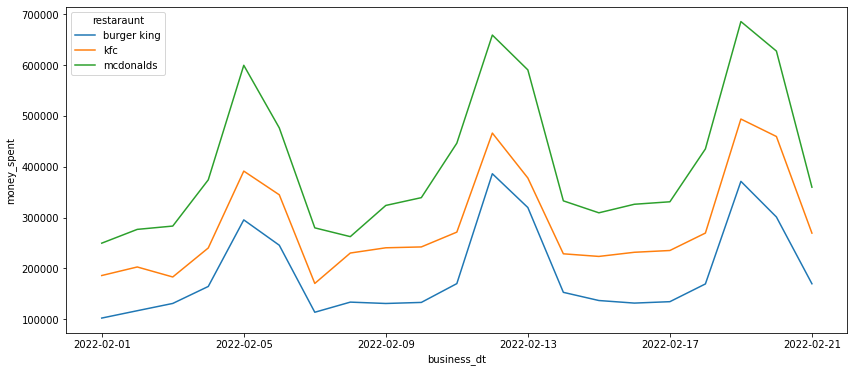

In [180]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=restaurants.groupby(["business_dt", "restaraunt"], as_index=False).agg({"money_spent":"sum"}),
                                                            x="business_dt", y="money_spent", hue="restaraunt")


&emsp;Сумма трат посетителей изменяется плавно с 1 по 21 февраля. На графике отчётливо видно, что наиболее прибыльные дни приходятся на 5, 12, 19 февраля. Это всё субботы, так что тенденция очевидена и вполне логична. Теперь визуализируем популярность ресторанов на основе числа посещений в день:

<AxesSubplot:xlabel='business_dt', ylabel='money_spent'>

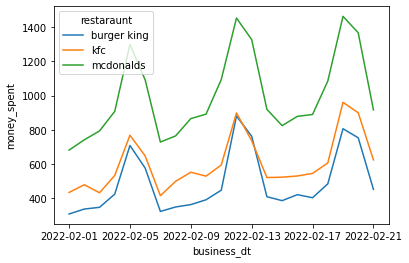

In [181]:
sns.lineplot(data=restaurants.groupby(["business_dt", "restaraunt"], as_index=False).agg({"money_spent":"count"}), x="business_dt", y="money_spent", hue="restaraunt")

На первом месте - Вкусно и Точка  
На втором - Троцкий  
На третьём - БК  
  
Далее посмотрим на рапределение возрастных групп по ресторанам с помощью барплота:

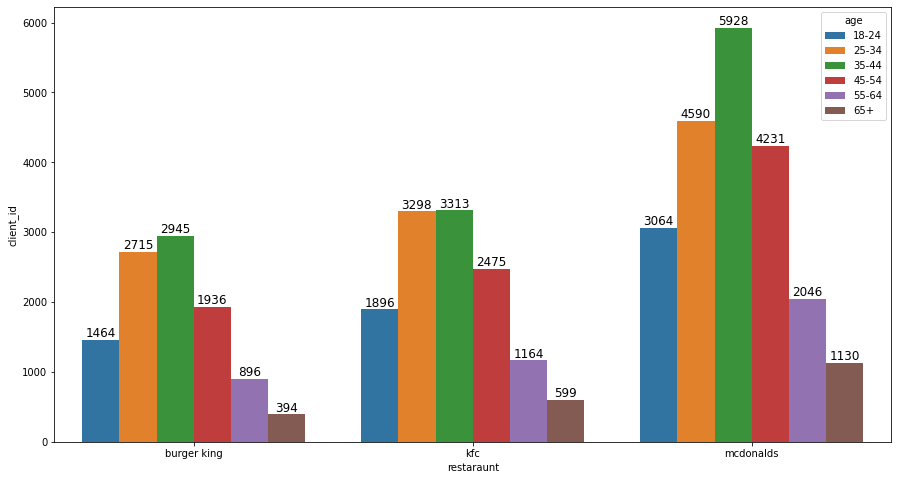

In [204]:
plt.figure(figsize=(15, 8))
plot = sns.barplot(data=restaurants.groupby(["age", "restaraunt"], as_index=False).agg({"client_id":"count"}), x="restaraunt", y="client_id", hue="age")
for container in plot.containers:
    plot.bar_label(container, size = 12)

&emsp;Как ни странно, основные потребители фастфуда - люди в возрасте от 25 до 44 лет. Молодёжь 18 - 24 года находится лишь на 4 месте после 45 - 54 летних. Считаю, что такая выборка нерепрезентативна и при сборе данных была допущена систематическая ошибка.  
&emsp;Последний вопрос - как визуализировать три параметра разом. В Python есть два способа: наложение графиков и subplots. Из - за разного шкалирования (суммы покупок намного выше, чем среднее) построим несколько графиков рядом

Text(0.5, 1.0, 'Средний чек')

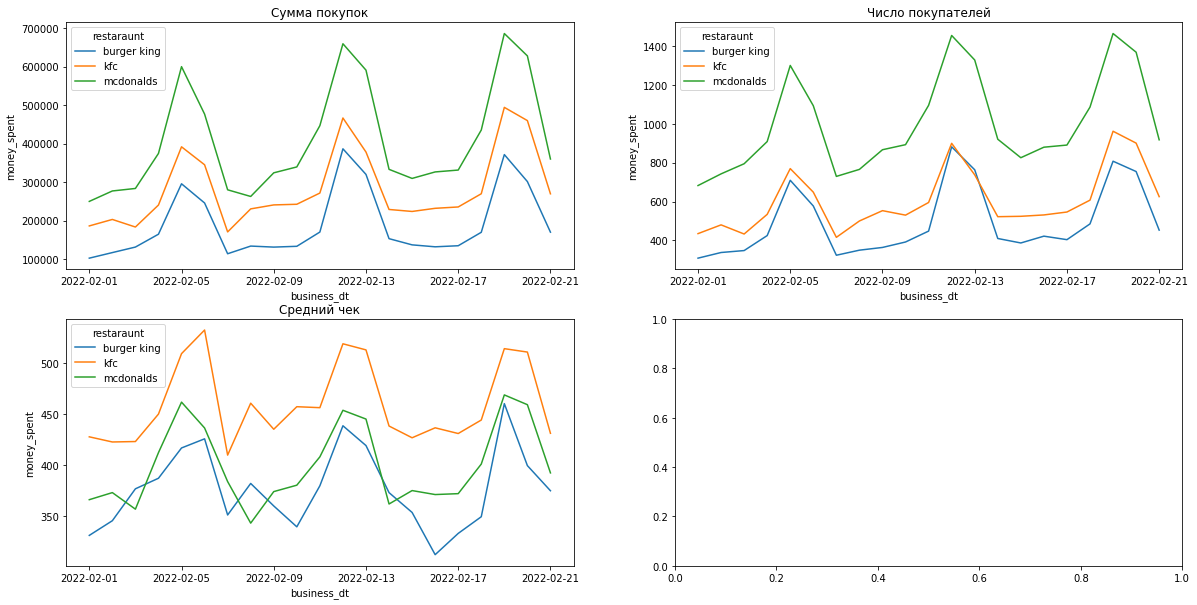

In [222]:
fig, ax = plt.subplots(2, 2, figsize =(20, 10))
data = restaurants.groupby(["business_dt", "restaraunt"], as_index=False)
sns.lineplot(data=data.agg({"money_spent":"sum"}), x="business_dt", y="money_spent", hue="restaraunt", ax=ax[0][0]).set_title("Сумма покупок")
sns.lineplot(data=data.agg({"money_spent":"count"}), x="business_dt", y="money_spent", hue="restaraunt", ax=ax[0][1]).set_title("Число покупателей")
sns.lineplot(data=data.agg({"money_spent":"mean"}), x="business_dt", y="money_spent", hue="restaraunt", ax=ax[1][0]).set_title("Средний чек")

&emsp;Конечно, визуализацию можно делать куда нагляднее, вплоть до добавления интерактивных возможностей plotly, но в целях описательной статистики этого будет достаточно (да и plotly на GitHub не загрузишь). По графикам можно сделать вывод, что хоть Вкусно и Точка является самым популярным рестораном и имеет наибольшую капитализацию, но kfc лидирует по среднему чеку. Так же средняя сумма покупок довольно изменчива по сравнению с другими показателями и для каждого ресторана можно определить пик и падение этой суммы.